# Markov Chain Monte Carlo With Turing

## Overview

This tutorial will give some examples of using `Turing.jl` and Markov
Chain Monte Carlo to sample from posterior distributions.

## Setup

In [2]:
using Turing
using Distributions
using Plots
default(fmt = :png) # the tide gauge data is long, this keeps images a manageable size
using LaTeXStrings
using StatsPlots
using Measures
using StatsBase
using Optim
using Random
using DataFrames
using DataFramesMeta
using Dates
using CSV

As this tutorial involves random number generation, we will set a random
seed to ensure reproducibility.

In [3]:
Random.seed!(1);

## Fitting A Linear Regression Model

Let’s start with a simple example: fitting a linear regression model to
simulated data.

> **Positive Control Tests**
>
> Simulating data with a known data-generating process and then trying
> to obtain the parameters for that process is an important step in any
> workflow.

### Simulating Data

The data-generating process for this example will be: $$
\begin{gather}
y = 5 + 2x + \varepsilon \\
\varepsilon \sim \text{Normal}(0, 3),
\end{gather}
$$ where $\varepsilon$ is so-called “white noise”, which adds
stochasticity to the data set. The generated dataset is shown in
[Figure 1](#fig-scatter-regression).

### Model Specification

The statistical model for a standard linear regression problem is $$
\begin{gather}
y = a + bx + \varepsilon \\
\varepsilon \sim \text{Normal}(0, \sigma).
\end{gather}
$$

Rearranging, we can rewrite the likelihood function as:
$$y \sim \text{Normal}(\mu, \sigma),$$ where $\mu = a + bx$. This means
that we have three parameters to fit: $a$, $b$, and $\sigma^2$.

Next, we need to select priors on our parameters. We’ll use relatively
generic distributions to avoid using the information we have (since we
generated the data ourselves), but in practice, we’d want to use any
relevant information that we had from our knowledge of the problem.
Let’s use relatively diffuse normal distributions for the trend
parameters $a$ and $b$ and a half-normal distribution (a normal
distribution truncated at 0, to only allow positive values) for the
variance $\sigma^2$, as recommended by Gelman (2006).

$$
\begin{gather}
a \sim \text{Normal(0, 10)} \\
b \sim \text{Normal(0, 10)} \\
\sigma \sim \text{Half-Normal}(0, 25)
\end{gather}
$$

### Using Turing

#### Coding the Model

`Turing.jl` uses the `@model` macro to specify the model function. We’ll
follow the setup in the [Turing
documentation](https://turinglang.org/dev/tutorials/05-linear-regression).

To specify distributions on parameters (and the data, which can be
thought of as uncertain parameters in Bayesian statistics), use a tilde
`~`, and use equals `=` for transformations (which we don’t have in this
case).

In [5]:
@model function linear_regression(x, y)
    # set priors
    σ ~ truncated(Normal(0, 25); lower=0)
    a ~ Normal(0, 10)
    b ~ Normal(0, 10)

    # compute the likelihood
    for i = 1:length(y)
        # compute the mean value for the data point
        μ = a + b * x[i]
        y[i] ~ Normal(μ, σ)
    end
end


linear_regression (generic function with 2 methods)

#### Fitting The Model

Now we can call the sampler to draw from the posterior. We’ll use the
[No-U-Turn
sampler](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo#No_U-Turn_Sampler)
(Hoffman & Gelman, 2014), which is a Hamiltonian Monte Carlo algorithm
(a different category of MCMC sampler than the Metropolis-Hastings
algorithm discussed in class). We’ll also use 4 chains so we can test
that the chains are well-mixed, and each chain will be run for 5,000
iterations[1]

[1] Hamiltonian Monte Carlo samplers often need to be run for fewer
iterations than Metropolis-Hastings samplers, as the exploratory step
uses information about the gradient of the statistical model, versus the
random walk of Metropolis-Hastings. The disadvantage is that this
gradient information must be available, which is not always the case for
external simulation models. Simulation models coded in Julia can usually
be automatically differentiated by Turing’s tools, however.

In [6]:
# set up the sampler
model = linear_regression(x, y)
n_chains = 4
n_per_chain = 5000
chain = sample(model, NUTS(), MCMCThreads(), n_per_chain, n_chains, drop_warmup=true)
@show chain


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/F9Hbk/src/sample.jl:296

┌ Info: Found initial step size
└   ϵ = 0.00625
┌ Info: Found initial step size
└   ϵ = 0.025

┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.003125

Sampling (1 threads):  50%|██████████████▌              |  ETA: 0:00:01

Sampling (1 threads): 100%|█████████████████████████████| Time: 0:00:01

chain = MCMC chain (5000×15×4 Array{Float64, 3})

Chains MCMC chain (5000×15×4 Array{Float64, 3}):
Iterations = 1001:1:6000
Number of chains = 4
Samples per chain = 5000
Wall duration = 15.78 seconds
Compute duration = 13.42 seconds
parameters = σ, a, b
internals = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size
Summary Statistics
 parameters mean std mcse ess_bulk ess_tail rhat ⋯
 Symbol Float64 Float64 Float64 Float64 Float64 Float64 ⋯
 σ 5.3881 0.9886 0.0097 10835.5758 10595.6871 1.0003 ⋯
 a 7.3483 2.1028 0.0231 8360.9948 8903.0798 1.0002 ⋯
 b 1.7993 0.1865 0.0021 8290.7784 8803.3686 1.0003 ⋯
 1 column omitted
 Quantiles
 parameters 2.5% 25.0% 50.0% 75.0% 97.5%
 Symbol Float64 Float64 Float64 Float64 Float64
 σ 3.8905 4.6873 5.2471 5.9322 7.7226
 a 3.1190 5.9784 7.3761 8.7487 11.4444
 b 1.4350 1.6773 1.7968 1.9214 2.1732

How can we interpret the output? The first parts of the summary
statistics are straightforward: we get the mean, standard deviation, and
Monte Carlo standard error (`mcse`) of each parameter. We also get
information about the effective sample size (ESS)[1] and $\hat{R}$,
which measures the ratio of within-chain variance and across-chain
variance as a check for convergence[2].

In this case, we can see that we were generally able to recover the
“true” data-generating values of $\sigma = 4$ and $b = 2$, but $a$ is
slightly off (the mean is 3, rather than the data-generating value of
5). In fact, there is substantial uncertainty about $a$, with a 95%
credible interval of $(3.1, 11.4)$ (compared to $(1.4, 2.2)$ for $b$).
This isn’t surprising: given the variance of the noise $\sigma^2$, there
are many different intercepts which could fit within that spread.

Let’s now plot the chains for visual inspection.

[1] The ESS reflects the efficiency of the sampler: this is an estimate
of the equivalent number of independent samples; the more correlated the
samples, the lower the ESS.

[2] The closer $\hat{R}$ is to 1, the better.

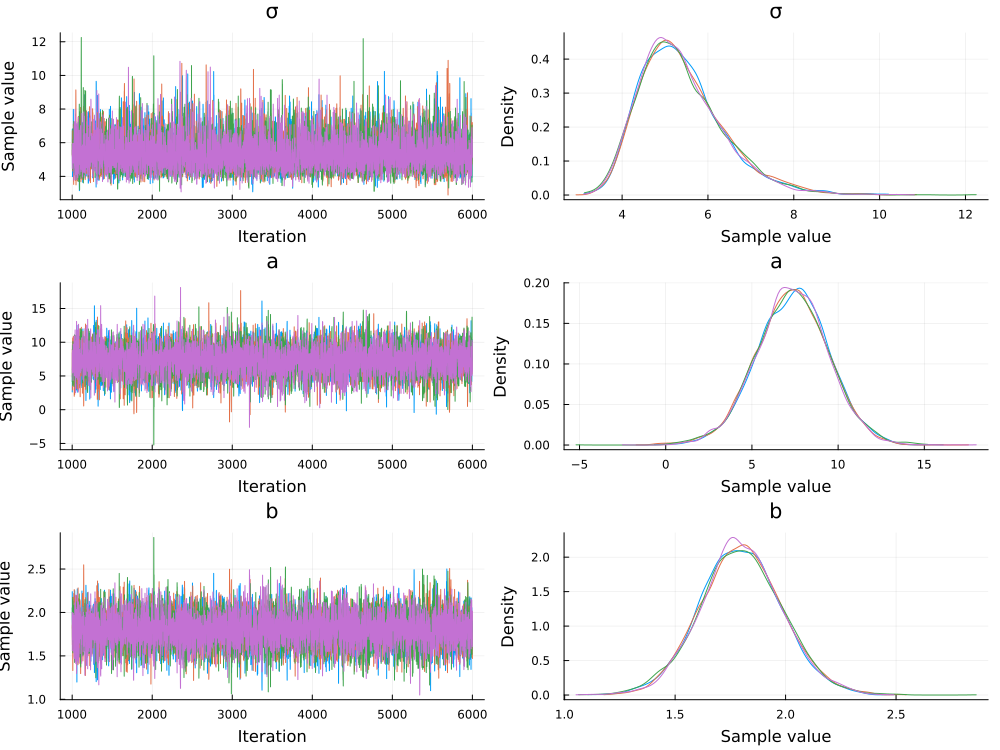

In [7]:
plot(chain)

We can see from [Figure 2](#fig-chains-regression) that our chains mixed
well and seem to have converged to similar distributions! The traceplots
have a “hairy caterpiller” appearance, suggesting relatively little
autocorrelation. We can also see how much more uncertainty there is with
the intercept $a$, while the slope $b$ is much more constrained.

Another interesting comparison we can make is with the
maximum-likelihood estimate (MLE), which we can obtain through
optimization.

In [8]:
mle_model = linear_regression(x, y)
mle = optimize(mle_model, MLE())
coef(mle)


We could also get the maximum *a posteriori* (MAP) estimate, which
includes the prior density, by replacing `MLE()` with `MAP()`.

### Model Diagnostics and Posterior Predictive Checks

One advantage of the Bayesian modeling approach here is that we have
access to a *generative model*, or a model which we can use to generate
datasets. This means that we can now use Monte Carlo simulation,
sampling from our posteriors, to look at how uncertainty in the
parameter estimates propagates through the model. Let’s write a function
which gets samples from the MCMC chains and generates datasets.

In [9]:
function mc_predict_regression(x, chain)
    # get the posterior samples
    a = Array(group(chain, :a))
    b = Array(group(chain, :b))
    σ = Array(group(chain, :σ))

    # loop and generate alternative realizations
    μ = a' .+ x * b'
    y = zeros((length(x), length(a)))
    for i = 1:length(a)
        y[:, i] = rand.(Normal.(μ[:, i], σ[i]))
    end
    return y
end


mc_predict_regression (generic function with 1 method)

Now we can generate a predictive interval and median and compare to the
data.

In [10]:
x_pred = 0:20
y_pred = mc_predict_regression(x_pred, chain)

21×20000 Matrix{Float64}:
 -0.440341  14.2143    3.73736    3.98402  …  13.9896   12.1475    5.46884
 -7.87522    4.36333  -7.19389    3.34537      9.48413  11.4606    3.81313
 17.3151     8.9222    0.292523  12.9925       7.6094   11.5593   10.3064
  2.28767    7.4078    9.09122    9.90026     21.4866   21.4643    4.38994
 23.1321     9.28746   9.56973   17.9069      14.6245    6.80164  23.3068
 10.0429    12.6741   23.6552    24.0107   …  17.07     12.9291   19.7511
 23.3753    33.5452   11.6653    14.3672      21.4006   24.598    25.4434
 11.6998     7.79426  16.9991    17.8128       8.01083  19.9234   17.2112
 16.3753    22.476    20.8614    20.1019      15.169    22.8508   21.7635
 17.1411    14.5313   32.2826    23.3866      27.5636   22.508    19.5266
 27.7594    28.5052   30.7478    35.5763   …  22.858    27.8321   17.396
 28.2636    24.2078   23.8358    27.5576      23.1143   30.4325   25.8818
 35.3991    39.3917   40.5648    30.0351      29.1015   31.9592   38.7204
 27.9246  

Notice the dimension of `y_pred`: we have 20,000 columns, because we
have 4 chains with 5,000 samples each. If we had wanted to subsample
(which might be necessary if we had hundreds of thousands or millions of
samples), we could have done that within `mc_linear_regression` before
simulation.

In [11]:
# get the boundaries for the 95% prediction interval and the median
y_ci_low = quantile.(eachrow(y_pred), 0.025)
y_ci_hi = quantile.(eachrow(y_pred), 0.975)
y_med = quantile.(eachrow(y_pred), 0.5)

Now, let’s plot the prediction interval and median, and compare to the
original data.

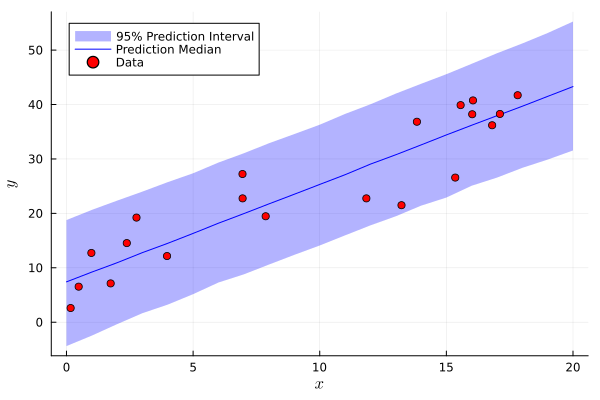

In [12]:
# plot prediction interval
plot(x_pred, y_ci_low, fillrange=y_ci_hi, xlabel=L"$x$", ylabel=L"$y$", fillalpha=0.3, fillcolor=:blue, label="95% Prediction Interval", legend=:topleft, linealpha=0)
plot!(x_pred, y_med, color=:blue, label="Prediction Median")
scatter!(x, y, color=:red, label="Data")


From [Figure 3](#fig-prediction-regression), it looks like our model
might be slightly under-confident, as with 20 data points, we would
expect 5% of them (or 1 data point) to be outside the 95% prediction
interval. It’s hard to tell with only 20 data points, though! We could
resolve this by tightening our priors, but this depends on how much
information we used to specify them in the first place. The goal
shouldn’t be to hit a specific level of uncertainty, but if there is a
sound reason to tighten the priors, we could do so.

Now let’s look at the residuals from the posterior median and the data.
The partial autocorrelations plotted in
[Figure 4](#fig-residuals-regression) are not fully convincing, as there
are large autocorrelation coefficients with long lags, but the dataset
is quite small, so it’s hard to draw strong conclusions. We won’t go
further down this rabbit hole as we know our data-generating process
involved independent noise, but for a real dataset, we might want to try
a model specification with autocorrelated errors to compare.

In [13]:
# calculate the median predictions and residuals
y_pred_data = mc_predict_regression(x, chain)
y_med_data = quantile.(eachrow(y_pred_data), 0.5)
residuals = y_med_data .- y

# plot the residuals and a line to show the zero
plot(pacf(residuals, 1:4), line=:stem, marker=:circle, legend=:false, grid=:false, linewidth=2, xlabel="Lag", ylabel="Partial Autocorrelation", markersize=8, tickfontsize=14, guidefontsize=16, legendfontsize=16)
hline!([0], linestyle=:dot, color=:red)


## Fitting Extreme Value Models to Tide Gauge Data

Let’s now look at an example of fitting an extreme value distribution
(namely, a [generalized extreme value
distribution](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution),
or GEV) to tide gauge data. GEV distributions have three parameters:

-   $\mu$, the *location* parameter, which reflects the positioning of
    the bulk of the GEV distribution;
-   $\sigma$, the *scale* parameter, which reflects the width of the
    bulk;
-   $\xi$, the *shape* parameter, which reflects the thickness and
    boundedness of the tail.

The shape parameter $\xi$ is often of interest, as there are three
classes of GEV distributions corresponding to different signs:

-   $\xi < 0$ means that the distribution is bounded;
-   $\xi = 0$ means that the distribution has a thinner tail, so the
    “extreme extremes” are less likely;
-   $\xi > 0$ means that the distribution has a thicker tail.

### Load Data

First, let’s load the data. We’ll use [data from the University of
Hawaii Sea Level Center](https://uhslc.soest.hawaii.edu/datainfo/)
(Caldwell et al., 2015) for San Francisco, from 1897-2013. If you don’t
have this data and are working with the notebook, download it
[here](https://uhslc.soest.hawaii.edu/data/csv/rqds/hourly/h551a.csv).
We’ll assume it’s in a `data/` subdirectory, but change the path as
needed.

The dataset consists of dates and hours and the tide-gauge measurement,
in mm. We’ll load the dataset into a `DataFrame`.

In [14]:
function load_data(fname)
    date_format = DateFormat("yyyy-mm-dd HH:MM:SS")
    df = @chain fname begin
        CSV.File(; delim=',', header=false)
        DataFrame
        rename("Column1" => "year",
                "Column2" => "month",
                "Column3" => "day",
                "Column4" => "hour",
                "Column5" => "gauge")
        # need to reformat the decimal date in the data file
        @transform :datetime = DateTime.(:year, :month, :day, :hour)
        # replace -99999 with missing
        @transform :gauge = ifelse.(abs.(:gauge) .>= 9999, missing, :gauge)
        select(:datetime, :gauge)
    end
    return df
end


load_data (generic function with 1 method)

In [15]:
dat = load_data("data/h551a.csv")
first(dat, 6)

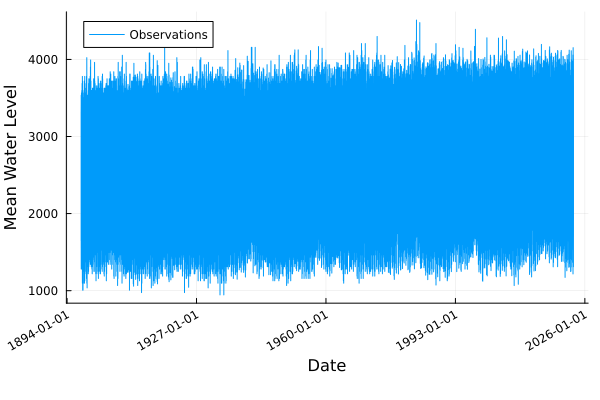

In [16]:
@df dat plot(:datetime, :gauge, label="Observations", bottom_margin=9mm)
xaxis!("Date", xrot=30)
yaxis!("Mean Water Level")


Next, we need to detrend the data to remove the impacts of sea-level
rise. We do this by removing a one-year moving average, centered on the
data point, per the recommendation of Arns et al. (2013).

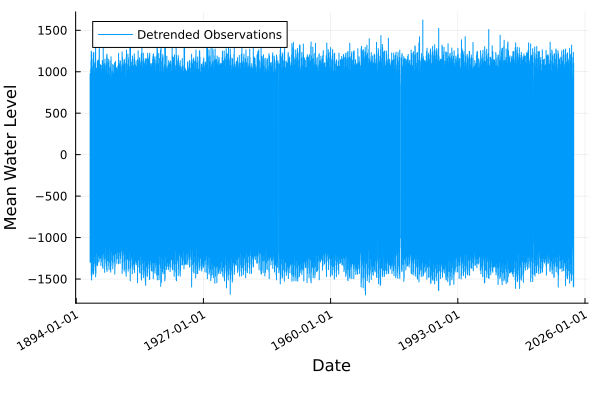

In [17]:
# calculate the moving average and subtract it off
ma_length = 366
ma_offset = Int(floor(ma_length/2))
moving_average(series,n) = [mean(@view series[i-n:i+n]) for i in n+1:length(series)-n]
dat_ma = DataFrame(datetime=dat.datetime[ma_offset+1:end-ma_offset], residual=dat.gauge[ma_offset+1:end-ma_offset] .- moving_average(dat.gauge, ma_offset))

# plot
@df dat_ma plot(:datetime, :residual, label="Detrended Observations", bottom_margin=9mm)
xaxis!("Date", xrot=30)
yaxis!("Mean Water Level")

The last step in preparing the data is to find the annual maxima. We can
do this using the `groupby`, `transform`, and `combine` functions from
`DataFrames.jl`, as below.

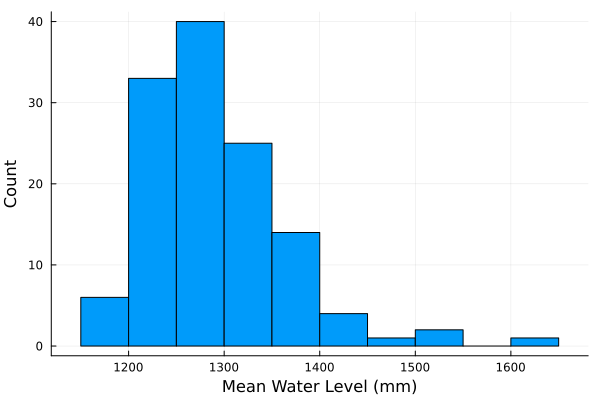

In [18]:
# calculate the annual maxima
dat_ma = dropmissing(dat_ma)
dat_annmax = combine(dat_ma -> dat_ma[argmax(dat_ma.residual), :],
                groupby(transform(dat_ma, :datetime => x->year.(x)), :datetime_function))
delete!(dat_annmax, nrow(dat_annmax))

# make a histogram of the maxima to see the distribution
histogram(dat_annmax.residual, label=false)
ylabel!("Count")
xlabel!("Mean Water Level (mm)")


### Fit The Model

In [19]:
@model function gev_annmax(y)               
    μ ~ Normal(1000, 100)
    σ ~ truncated(Normal(0, 100); lower=0)
    ξ ~ Normal(0, 0.5)

    y ~ GeneralizedExtremeValue(μ, σ, ξ)
end

gev_model = gev_annmax(dat_annmax.residual)
n_chains = 4
n_per_chain = 5000
gev_chain = sample(gev_model, NUTS(), MCMCThreads(), n_per_chain, n_chains; drop_warmup=true)
@show gev_chain


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/F9Hbk/src/sample.jl:296

┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.0125

┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2

Sampling (1 threads):  50%|██████████████▌              |  ETA: 0:00:04

Sampling (1 threads): 100%|█████████████████████████████| Time: 0:00:08

gev_chain = MCMC chain (5000×15×4 Array{Float64, 3})

Chains MCMC chain (5000×15×4 Array{Float64, 3}):
Iterations = 1001:1:6000
Number of chains = 4
Samples per chain = 5000
Wall duration = 14.96 seconds
Compute duration = 14.56 seconds
parameters = μ, σ, ξ
internals = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size
Summary Statistics
 parameters mean std mcse ess_bulk ess_tail rh ⋯
 Symbol Float64 Float64 Float64 Float64 Float64 Float ⋯
 μ 1257.8174 5.6701 0.0513 12216.6653 12642.3312 1.00 ⋯
 σ 57.1982 4.3214 0.0366 14201.5441 12575.6044 1.00 ⋯
 ξ 0.0292 0.0625 0.0008 5915.1552 7463.8803 1.00 ⋯
 2 columns omitted
 Quantiles
 parameters 2.5% 25.0% 50.0% 75.0% 97.5%
 Symbol Float64 Float64 Float64 Float64 Float64
 μ 1246.8628 1253.9821 1257.8132 1261.6027 1269.2078
 σ 49.4284 54.1859 56.9353 59.9665 66.3174
 ξ -0.0811 -0.0151 0.0250 0.0699 0.1627

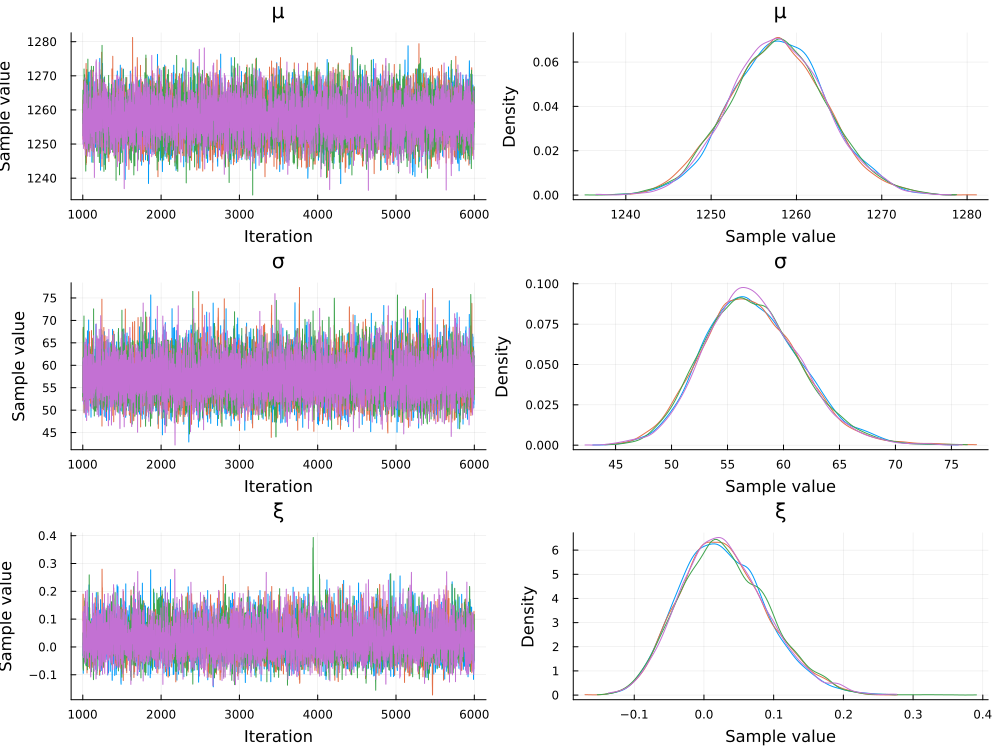

In [20]:
plot(gev_chain)

From [Figure 8](#fig-gev-traceplot), it looks like all of the chains
have converged to the same distribution; the Gelman-Rubin diagnostic is
also close to 1 for all parameters. Next, we can look at a corner plot
to see how the parameters are correlated.

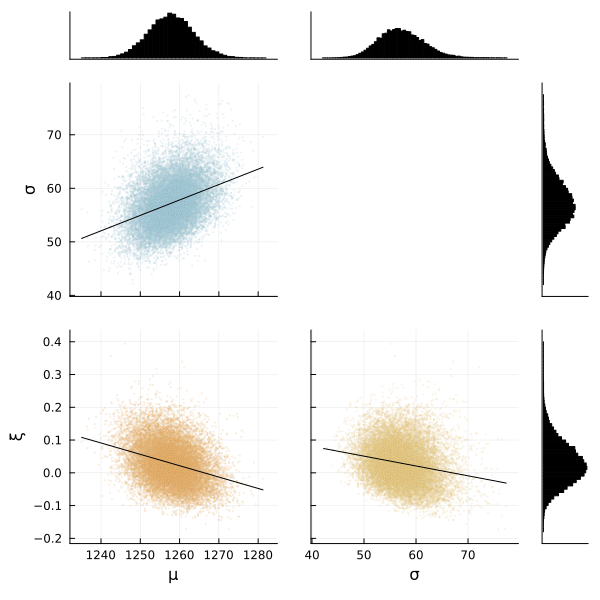

In [21]:
corner(gev_chain)

[Figure 9](#fig-gev-corner) suggests that the location and scale
parameters $\mu$ and $\sigma$ are positively correlated. This makes some
intuitive sense, as increasing the location parameter shifts the bulk of
the distribution in a positive direction, and the increasing scale
parameter then increases the likelihood of lower values. However, if
these parameters are increased, the shape parameter $\xi$ decreases, as
the tail of the GEV does not need to be as thick due to the increased
proximity of outliers to the bulk.

Arns, A., Wahl, T., Haigh, I. D., Jensen, J., & Pattiaratchi, C. (2013).
Estimating extreme water level probabilities: A comparison of the direct
methods and recommendations for best practise. *Coast. Eng.*, *81*,
51–66. <https://doi.org/10.1016/j.coastaleng.2013.07.003>

Caldwell, P. C., Merrifield, M. A., & Thompson, P. R. (2015). Sea level
measured by tide gauges from global oceans — the joint archive for sea
level holdings (NCEI accession 0019568). NOAA National Centers for
Environmental Information (NCEI). <https://doi.org/10.7289/V5V40S7W>

Gelman, A. (2006). Prior distributions for variance parameters in
hierarchical models (comment on article by Browne and Draper). *Bayesian
Anal.*, *1*(3), 515–533. <https://doi.org/10.1214/06-BA117A>

Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn sampler: Adaptively
setting path lengths in Hamiltonian Monte Carlo. *J. Mach. Learn. Res.*,
*15*(47), 1593–1623.